In [15]:

CUDA_LAUNCH_BLOCKING=1
import torch
import torch.nn as nn
import numpy as np 


import random

import tqdm
import matplotlib.pyplot as plt

In [16]:
device = torch.device("cuda:5")

H = torch.load("./test/original_weights.pt")["H"].to(device).float()
weights = torch.load("./test/original_weights.pt")["weights"].to(device).float()    

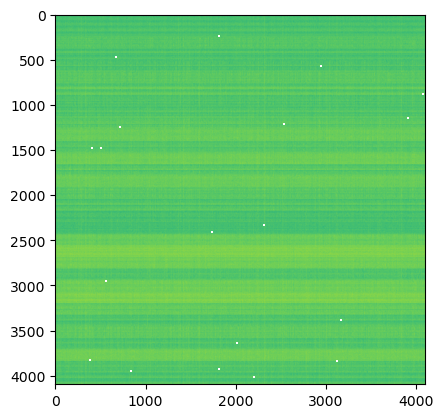

In [17]:
plt.imshow(torch.log(torch.abs(weights)).cpu().numpy())   

In [18]:
norm_0 = torch.norm(weights, dim = 0)
norm_1 = torch.norm(weights, dim = 1)

keep_top = 0.01
if keep_top != 0:

    top_threshold = torch.topk(torch.concatenate((norm_0, norm_1), dim = 0), 
                            int(keep_top * weights.shape[0]), largest = True).values[-1]

    mask_0 = norm_0 < top_threshold
    mask_1 = norm_1 < top_threshold
else:
    mask_0 = torch.ones_like(norm_0).bool()
    mask_1 = torch.ones_like(norm_1).bool()
mask_total = mask_0.unsqueeze(0) * mask_1.unsqueeze(1)

print("mask total bits", (~mask_total).sum().item()*16/(weights.shape[0]*weights.shape[1]))

mask total bits 0.15587711334228516


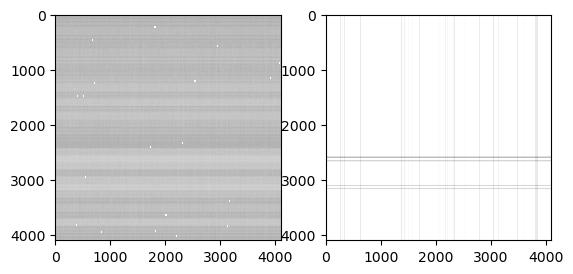

In [19]:
fig,axs = plt.subplots(1,2)
plt.imshow(mask_total.cpu().numpy(), cmap = "gray")
plt.sca(axs[0])
plt.imshow(torch.log(torch.abs(weights)).cpu().numpy(), cmap = "gray")

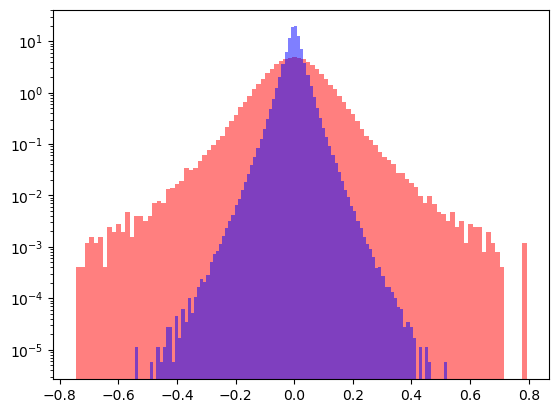

In [20]:
plt.hist(weights[~mask_total].cpu().numpy().flatten(), bins = 100,
            density = True, alpha = 0.5, color = "red")
plt.hist(weights[mask_total].cpu().numpy().flatten(), bins = 100,
            density = True, alpha = 0.5, color = "blue")
plt.yscale("log")
plt.show()


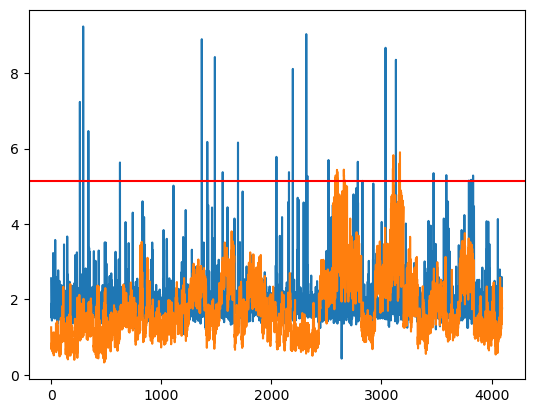

In [21]:
plt.plot(norm_0.cpu().numpy())
plt.plot(norm_1.cpu().numpy())
plt.axhline(top_threshold.cpu().item(), color = "red")

In [22]:
W_non_sparse = weights[mask_1, :][:, mask_0]
W_sparse = weights[~mask_total]
# print(W_non_sparse.shape)
# print(torch.sum(mask_total, dim = 0), torch.sum(mask_total, dim = 1))

In [23]:
def reconstruct_weights(weight_non_sparse, weights_sparse,mask):
    weights_reconstructed = torch.zeros(mask.shape, device = mask.device)
    weights_reconstructed[~mask] = weights_sparse.flatten()
    weights_reconstructed[mask] = weight_non_sparse.flatten()
    return weights_reconstructed

In [24]:
w_reconstruct = reconstruct_weights(W_non_sparse, W_sparse, mask_total)
torch.mean(torch.abs(weights - w_reconstruct))

tensor(0., device='cuda:5')

In [25]:
low_rank = 512

U, S, V = torch.svd(W_non_sparse)

# print(U.shape, S.shape, V.shape)
A_orig = U[:, :low_rank] @ torch.sqrt(torch.diag(S[:low_rank]))
B_orig = torch.sqrt(torch.diag(S[:low_rank])) @ V[:, :low_rank].t()

w_reconstruct = reconstruct_weights(A_orig @ B_orig, W_sparse, mask_total)
torch.mean(torch.abs(weights - w_reconstruct))


tensor(0.0035, device='cuda:5')

In [26]:
lambda_ = 0
H_use = (H + lambda_*torch.eye(H.shape[0]).to(device))/H.shape[0]

In [27]:
diff = weights - w_reconstruct
torch.einsum("ij,jk,ik->", diff, H_use, diff) 

tensor(0.4724, device='cuda:5')

In [28]:
loggers = {}

In [29]:
#fine tune to fit
lr = 1e-4

A = A_orig.clone().requires_grad_()
B = B_orig.clone().requires_grad_()
optimizer = torch.optim.Adam([A, B], lr=lr) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = 0.9)

losses = []
prev_loss = 1e9


for i in range(1000):
    optimizer.zero_grad()
    diff = weights - reconstruct_weights(A @ B, W_sparse, mask_total)
    # print(torch.mean(torch.abs(diff)).item())
    # print(diff.shape)
    # print(H.shape)
    loss = torch.einsum("ij,jk,ik->", diff, H_use, diff)
    # print(loss.item())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i % 100 == 0:
        print(loss.item())
        # raise Exception("stop")
    
    if loss.item() > prev_loss:
        scheduler.step()
print(loss.item())
loggers[lr] = losses

0.47243475914001465
0.18640244007110596
0.17164292931556702
0.16624107956886292
0.1637376844882965
0.16243842244148254
0.16171713173389435
0.16129139065742493
0.16103319823741913
0.16087380051612854
0.16075614094734192


In [30]:
A = A.detach()
B = B.detach()

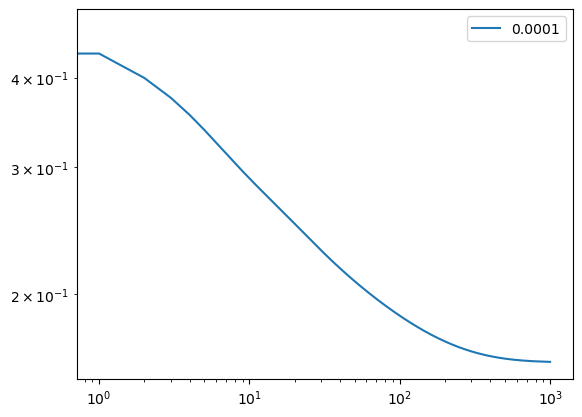

In [31]:
for lr, losses in loggers.items():
    plt.plot(losses, label=str(lr)) 

plt.yscale("log")
plt.legend()  
plt.xscale("log")  

torch.Size([512]) torch.Size([512])


(array([5.22873727e+01, 5.14766590e+01, 5.03210370e+01, 4.86095617e+01,
        4.60772605e+01, 4.34485622e+01, 4.03976212e+01, 3.69610917e+01,
        3.36798366e+01, 3.02493849e+01, 2.67164413e+01, 2.35200388e+01,
        2.03683715e+01, 1.75128224e+01, 1.49115424e+01, 1.24793903e+01,
        1.03699090e+01, 8.63158553e+00, 7.06527615e+00, 5.69176107e+00,
        4.51392643e+00, 3.57679605e+00, 2.83043967e+00, 2.25263400e+00,
        1.74957941e+00, 1.36023883e+00, 1.08490086e+00, 8.48525812e-01,
        6.27158704e-01, 4.86026349e-01, 3.54995493e-01, 2.77935496e-01,
        2.32911677e-01, 1.68839320e-01, 1.29010557e-01, 1.03035277e-01,
        8.65842665e-02, 7.21535554e-02, 4.90643077e-02, 4.41580749e-02,
        4.30034226e-02, 2.77070274e-02, 2.39549267e-02, 1.96258111e-02,
        1.52965195e-02, 1.76055070e-02, 1.35648380e-02, 1.06787501e-02,
        1.03900887e-02, 8.94706093e-03, 6.92672579e-03, 6.63814198e-03,
        5.19504434e-03, 6.06091225e-03, 2.88613575e-03, 2.597533

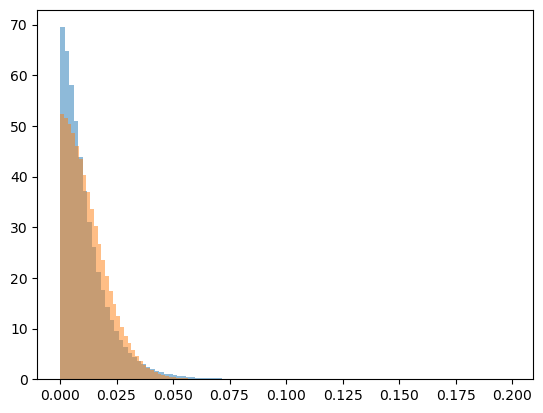

In [32]:
# plt.hist(weights.flatten().cpu().numpy(), bins=100, alpha=0.5, label="weights",
#             density=True)
A_norm = torch.norm(A, dim = 0)
B_norm = torch.norm(B, dim = 1)
print(A_norm.shape, B_norm.shape)
plt.hist(torch.abs(A/A_norm.unsqueeze(0)).flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="A",
            density=True)
plt.hist(torch.abs(B/B_norm.unsqueeze(1)).flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="B",
          density=True)
# plt.yscale("log")
# plt.xscale("log")

In [33]:
sparse_frac = 0.005

if sparse_frac != 0:
    top_threshold = torch.topk(torch.concatenate((torch.abs(A).flatten(), torch.abs(B).flatten()), dim = 0),
                                int(sparse_frac * (A.numel() + B.numel())), largest = True).values[-1]
    print(top_threshold)

    A_mask = torch.abs(A) < top_threshold
    B_mask = torch.abs(B) < top_threshold
else:
    A_mask = torch.ones_like(A).bool()
    B_mask = torch.ones_like(B).bool()

print("A num selected", (~A_mask).sum().item()/A_mask.numel(), "B num selected", (~B_mask).sum().item()/B_mask.numel())

tensor(0.1280, device='cuda:5')
A num selected 0.006874482869575876 B num selected 0.00312269825681316


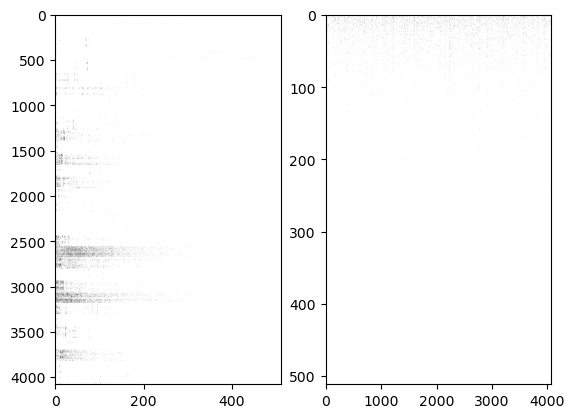

In [34]:
fig, axs = plt.subplots(1,2)
plt.sca(axs[0])
plt.imshow(A_mask.cpu().numpy(), cmap = "gray",aspect = "auto")
plt.sca(axs[1])
plt.imshow(B_mask.cpu().numpy(), cmap = "gray", aspect = "auto")

torch.Size([512]) torch.Size([512])
torch.Size([512]) torch.Size([512])


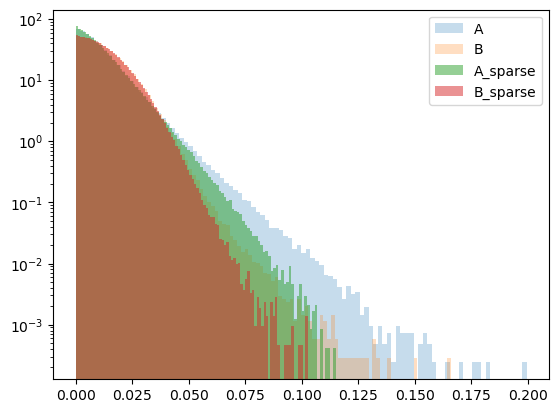

In [35]:
A_sparse = A[~A_mask]
B_sparse = B[~B_mask]

A_replaced = A.clone()
A_replaced[~A_mask] = 0
B_replaced = B.clone()
B_replaced[~B_mask] = 0


A_norm = torch.norm(A, dim = 0)
B_norm = torch.norm(B, dim = 1)
print(A_norm.shape, B_norm.shape)
plt.hist(torch.abs(A/A_norm.unsqueeze(0)).flatten().detach().cpu().numpy(), bins=100, alpha=0.25, label="A",
            density=True)
plt.hist(torch.abs(B/B_norm.unsqueeze(1)).flatten().detach().cpu().numpy(), bins=100, alpha=0.25, label="B",
          density=True)


A_norm_ = torch.norm(A_replaced, dim = 0)
B_norm_ = torch.norm(B_replaced, dim = 1)
print(A_norm.shape, B_norm.shape)
plt.hist(torch.abs(A_replaced/A_norm.unsqueeze(0)).flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="A_sparse",
            density=True)
plt.hist(torch.abs(B_replaced/B_norm.unsqueeze(1)).flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="B_sparse",
          density=True)

plt.legend()
plt.yscale("log")   
plt.show()

In [36]:
A_to_quantize = A_replaced/A_norm.unsqueeze(0)
B_to_quantize = B_replaced/B_norm.unsqueeze(1)

n_bits_per_value = 4

A_codebook = torch.linspace(A_to_quantize.min().item(), A_to_quantize.max().item(), 2**n_bits_per_value).to(device)
B_codebook = torch.linspace(B_to_quantize.min().item(), B_to_quantize.max().item(), 2**n_bits_per_value).to(device) 


def round_to_the_nearest(x, codebook):
    return torch.argmin(torch.abs(x.flatten().unsqueeze(0) - codebook.unsqueeze(1)), dim = 0).reshape(x.shape)

def stochastic_round(x,codebook):
    errors = torch.abs(x.flatten().unsqueeze(0) - codebook.unsqueeze(1)) #shape (n_codebook, n_values)
    #pick the top 2 closest values
    top_2, index_top_2 = torch.topk(errors, 2, dim = 0, largest = False)
    

A_codes_master = round_to_the_nearest(A_to_quantize, A_codebook)
B_codes_master = round_to_the_nearest(B_to_quantize, B_codebook)


def reconstruct_W(A_codes,B_codes,A_codebook, B_codebook,
                  A_norm, B_norm, A_mask, B_mask,
                  A_sparse, B_sparse,
                  W_sparse, W_mask):
    
    A_reconstructed_raw = A_codebook[A_codes]
    B_reconstructed_raw = B_codebook[B_codes]
    A_reconstructed_raw.retain_grad()
    B_reconstructed_raw.retain_grad()
    
    A_reconstructed = A_reconstructed_raw * A_norm.unsqueeze(0)
    B_reconstructed = B_reconstructed_raw * B_norm.unsqueeze(1)
    
    A_reconstructed[~A_mask] = A_sparse
    B_reconstructed[~B_mask] = B_sparse
    
    W_reconstructed = reconstruct_weights(A_reconstructed @ B_reconstructed, W_sparse, W_mask)
    return W_reconstructed, A_reconstructed_raw, B_reconstructed_raw

In [51]:
def stochastic_round(x,codebook):
    errors = torch.abs(x.flatten().unsqueeze(0) - codebook.unsqueeze(1)) #shape (n_codebook, n_values)
    #pick the top 2 closest values
    error_top_2, index_top_2 = torch.sort(errors, dim = 0)
    # print(error_top_2.shape, index_top_2.shape)
    error_top_2 = error_top_2[:2]
    error1 = error_top_2[0]
    error2 = error_top_2[1]
    
    index_top_2 = index_top_2[:2]
    # gap = torch.abs(codebook[index_top_2[1]] - codebook[index_top_2[0]])
    
    # p_round_1 = error2/(error1 + error2)
    # p_round_2 = error1/(error1 + error2)
    #sample from the top 2
    p = torch.rand(x.flatten().shape, device = x.device)
    # print(p.shape, index_top_2[0].shape, error1.shape, error2.shape)
    index_use = torch.where(p < error1/(error1 + error2), index_top_2[0], index_top_2[1])
    
    return index_use.reshape(x.shape)   
    
    
    


In [52]:
a = torch.tensor([1,2,3]).float()
torch.norm(torch.stack([a,a,a]), dim = 0)

tensor([1.7321, 3.4641, 5.1962])

In [56]:
A_codebook_use = A_codebook.clone().requires_grad_()
B_codebook_use = B_codebook.clone().requires_grad_()
A_codes = A_codes_master.clone()
B_codes = B_codes_master.clone()

optimizer = torch.optim.Adam([A_codebook_use, B_codebook_use], lr=1e-3)
losses = []

n_warmup_steps = 50 #during these steps just round to the nearest
n_steps = 250
n_steps_between_updates = 10


for i in range(n_steps):
    optimizer.zero_grad()
    W_reconstructed,A_reconstructed,B_reconstructed = reconstruct_W(A_codes,B_codes,
                                                A_codebook_use, B_codebook_use,
                                                A_norm, B_norm, A_mask, B_mask,
                                                A_sparse, B_sparse,
                                                W_sparse, mask_total)
    diff = weights - W_reconstructed
    loss = torch.einsum("ij,jk,ik->", diff, H_use, diff)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    # A_codes = round_to_the_nearest(A_to_quantize, A_codebook_use)
    # B_codes = round_to_the_nearest(B_to_quantize, B_codebook_use)
    if i % n_steps_between_updates == 0 and i > n_warmup_steps:
        A_codes = stochastic_round(A_to_quantize, A_codebook_use)
        B_codes = stochastic_round(B_to_quantize, B_codebook_use)
    # raise Exception("stop")
    A_reconstructed.grad = None
    B_reconstructed.grad = None
        
    if i % 10 == 0:
        print(loss.item())
    
    

16.944408416748047
14.914237976074219
14.585054397583008
14.529731750488281
14.53580093383789
14.519285202026367
14.513989448547363
59.0052490234375
31.148019790649414
20.588035583496094
19.72443962097168
15.45263385772705
12.437521934509277
10.542867660522461
9.319091796875
8.510640144348145
8.234618186950684
7.667362213134766
7.5087127685546875
7.288048267364502
7.2429728507995605
7.114911079406738
7.064361095428467
7.039697647094727
7.026817321777344


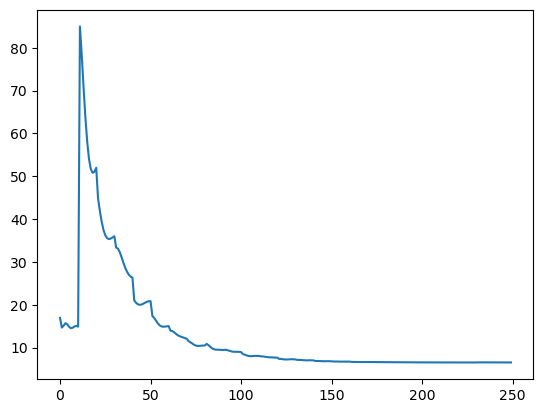

In [55]:
plt.plot(losses)

In [148]:
n_bits = 0
n_bits += A_codes.numel() * n_bits_per_value
n_bits += B_codes.numel() * n_bits_per_value
n_bits += A_codebook_use.numel() * 16
n_bits += B_codebook_use.numel() * 16
n_bits += A_sparse.numel() * 16 * 3
n_bits += B_sparse.numel() * 16 * 3
n_bits += W_sparse.numel() * 16 + mask_0.numel()*8 + mask_1.numel()*8
print(n_bits, n_bits/(weights.numel()))

20378240 1.2146377563476562


In [55]:
A_codes.numel()

2088448

In [52]:
W_sparse.numel()/weights.numel()

0.009742319583892822

(array([  57077.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  864693.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
        1081792.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

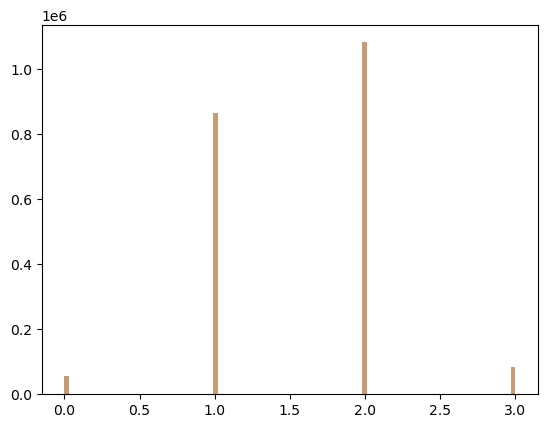

In [28]:
plt.hist(A_codes_new.flatten().cpu().numpy(), bins = 100, alpha = 0.5, label = "A_codes_new")
plt.hist(A_codes.flatten().cpu().numpy(), bins = 100, alpha = 0.5, label = "A_codes")

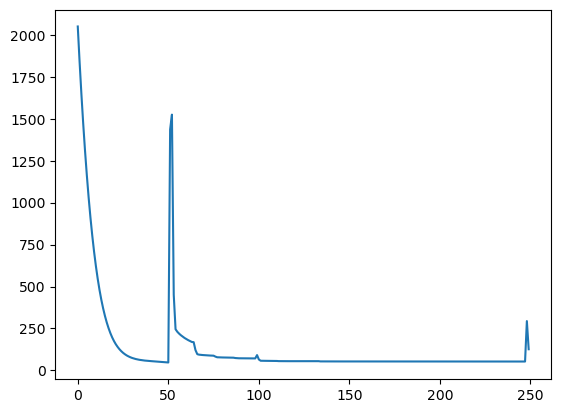

In [29]:
plt.plot(losses)

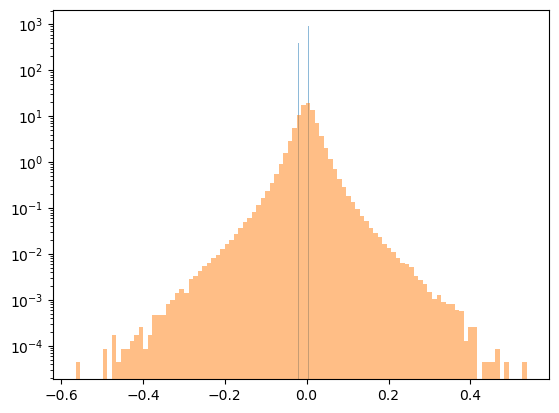

In [70]:
plt.hist(A_codebook[A_codes].flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="A_quantized",
            density=True)
plt.hist(A.flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="A",
            density=True)
plt.yscale("log")